## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import os 
from glob import glob
import cv2
from PIL import Image
import random
from io import BytesIO
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

UsageError: Line magic function `%%capture` not found.


## Data I/O

In [27]:
INPUT_PATH = './input'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")
TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]
test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
test_ids = [s[len(TEST_DATA)+1:-4] for s in test_files]

In [31]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    elif "Foreground" in image_type:
        ext = 'jpg'
        data_path = Foreground
        suffix = ''
    elif "Background" in image_type:
        ext = 'jpg'
        data_path = Background
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))
def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()




## Dataset description

In [33]:
!ls ./input/train/ | wc -l
!ls ./input/train_masks/ | wc -l
!ls ./input/test/ | wc -l
!ls ./input/Foreground/ | wc -l
!ls ./input/Background/ | wc -l
!ls ./input/background_images/ | wc -l

5088
5088
100064
5089
2010
1


In [34]:
!ls ./input/train/ | grep c_01.jpg

00087a6bd4dc_01.jpg
0ee135a3cccc_01.jpg
11fcda0a9e1c_01.jpg
2267f4aa0d2c_01.jpg
344ece157efc_01.jpg
3f8d611822bc_01.jpg
430f0cb5666c_01.jpg
4bea0766c14c_01.jpg
4f1f065d78ac_01.jpg
5588758ee21c_01.jpg
8d5423cb763c_01.jpg
b1a27da4f01c_01.jpg
d8e1c401ac3c_01.jpg


Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


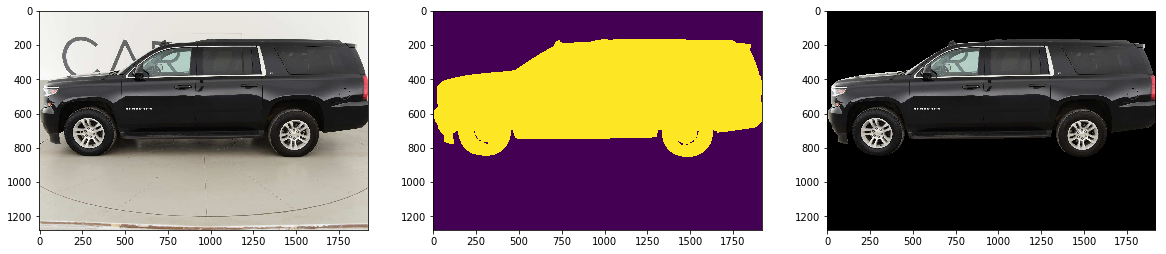

In [35]:
image_id = train_ids[0]

plt.figure(figsize=(20, 20))
img = get_image_data(image_id, "Train")
mask = get_image_data(image_id, "Train_mask")
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked)

## Creating foreground images ( cars+masks)

In [37]:
path = './input/Foreground'

In [38]:
for i in range(len(train_ids)):
    
    image_id = train_ids[i]

    plt.figure(figsize=(20, 20))
    img = get_image_data(image_id, "Train")
    mask = get_image_data(image_id, "Train_mask")
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), img_masked)

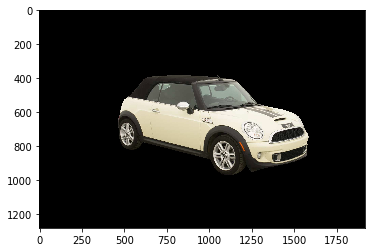

In [39]:
foregroundimg= cv2.imread("./input/Foreground/"+str(train_ids[5]+".jpg"))
plt.imshow(foregroundimg)

## Approach-1: Tinting image with alpha channel 

### read the test car image

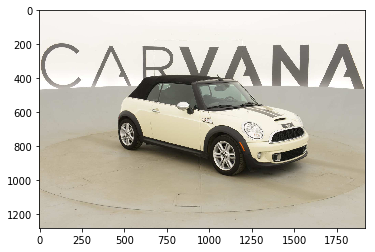

In [43]:
#read the test car image
image_id = train_ids[5]
test_img= get_image_data(image_id, "Train")
plt.imshow(test_img)

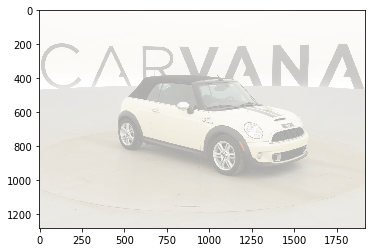

In [44]:
original = test_img
orginal_array = np.array(i, dtype=np.float)
orginal_array /= 255.0
alpha_channel_90 = np.ones(orginal_array.shape, dtype=np.float)*90.0 #make dimmer
alpha_channel_300 = np.ones(orginal_array.shape, dtype=np.float)*300.0 #make brighter 
alpha_channel_500 = np.ones(orginal_array.shape, dtype=np.float)*500.0 #make brighter 
output_90 = orginal_array*alpha_channel_90
output_300 = orginal_array*alpha_channel_300
output_500 = orginal_array*alpha_channel_500
cv2.imwrite("output_90.jpg",output_90)
cv2.imwrite("output_300.jpg",output_300)
cv2.imwrite("output_500.jpg",output_500)

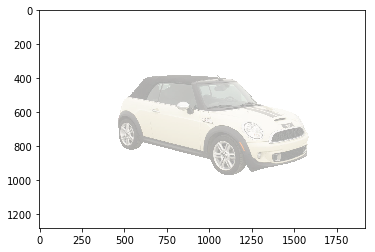

In [45]:
#create a tinted foreground image (car-tinted+mask)
image_id = train_ids[5]
mask = get_image_data(image_id, "Train_mask")
#mask_inverted=cv2.bitwise_not(mask)
foregroundimg_tinted = cv2.bitwise_and(output_500, output_500, mask=mask)
plt.imshow(foregroundimg_tinted)

### reading a background image from background images folder and resizig it to the size of mask image


In [57]:
del img_resized,test_img,img_BGRA,complete_image_tinted,foregroundimg_tinted

## Approach-2: Tinting image with mask

### read the test car image

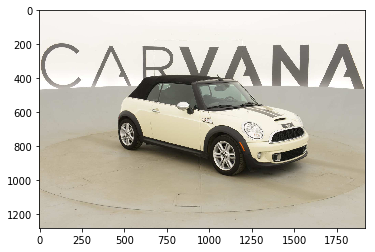

In [59]:
#read the test car image
image_id = train_ids[5]
test_img= get_image_data(image_id, "Train")
plt.imshow(test_img)

###  Reading the foreground image and convert it to grayscale


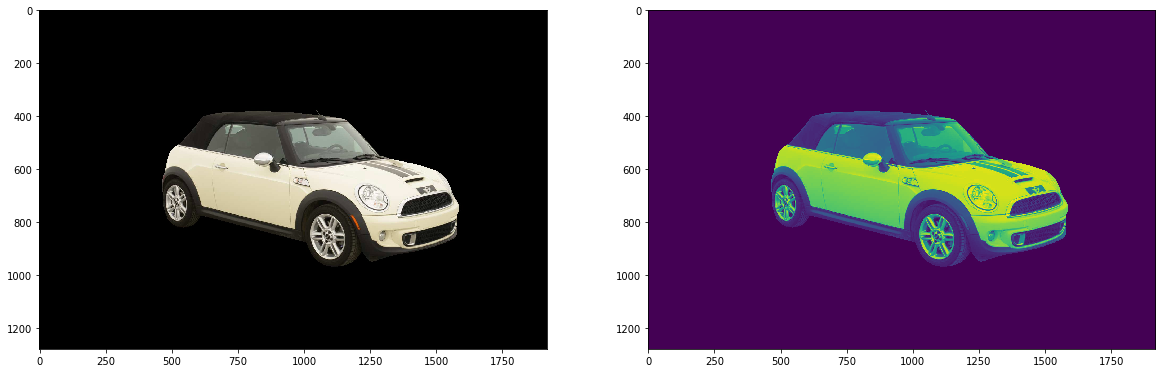

In [60]:
# read the foreground image and convert it to grayscale

foregroundimg= cv2.imread("./input/Foreground/"+str(train_ids[5]+".jpg"))
foregroundimg_grayscale=cv2.imread("./input/Foreground/"+str(train_ids[5]+".jpg"),0)
#foregroundimg = cv2.cvtColor(foregroundimg, cv2.COLOR_BGR2RGB)
#foregroundimg_grayscale=cv2.cvtColor(foregroundimg, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(foregroundimg)
plt.subplot(122)
plt.imshow(foregroundimg_grayscale)

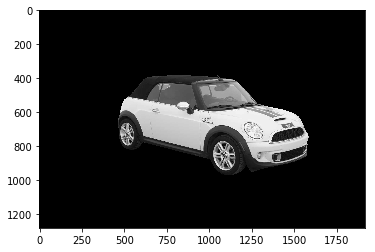

In [61]:
# convert the foreground image with one channel to three channels and display

foregroundimg_grayscale_3chan = np.stack((foregroundimg_grayscale,)*3, axis=-1)
#cv2.imwrite('./',foregroundimg_grayscale_3chan)
plt.imshow(foregroundimg_grayscale_3chan)

In [62]:
path="."
cv2.imwrite(os.path.join(path ,"foreground_grayscale"+".jpg"), foregroundimg_grayscale)
cv2.imwrite(os.path.join(path ,"foregroundimg_grayscale_3chan"+".jpg"), foregroundimg_grayscale_3chan)
cv2.imwrite(os.path.join(path ,"foregroundimg"+".jpg"), foregroundimg)

True

In [63]:
foregroundimg.shape,foregroundimg_grayscale.shape,foregroundimg_grayscale_3chan.shape

((1280, 1918, 3), (1280, 1918), (1280, 1918, 3))

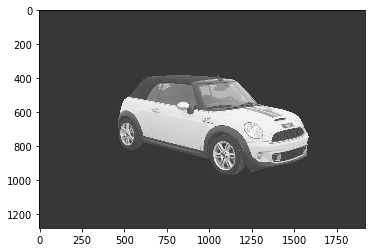

In [64]:
b_channel, g_channel, r_channel = cv2.split(foregroundimg_grayscale_3chan)
alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 200 #creating a dummy alpha channel image.
img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
plt.imshow(img_BGRA)

### temp trial for cone

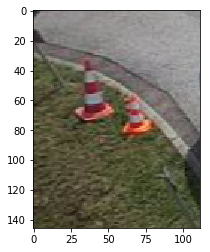

In [23]:
temp=cv2.imread("temp.png")
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
# temp_grayscale=cv2.imread("temp.png",0)
# temp_grayscale_3chan = np.stack((temp_grayscale,)*3, axis=-1)
plt.imshow(temp)

In [76]:
import numpy as np
import cv2
original = cv2.imread('original.png')
orginal_array = np.array(i, dtype=np.float)
orginal_array /= 255.0
alpha_channel_90 = np.ones(orginal_array.shape, dtype=np.float)*90.0 #make dimmer
alpha_channel_300 = np.ones(orginal_array.shape, dtype=np.float)*300.0 #make brighter 
alpha_channel_500 = np.ones(orginal_array.shape, dtype=np.float)*500.0 #make brighter 
output_90 = orginal_array*alpha_channel_90
output_300 = orginal_array*alpha_channel_300
output_500 = orginal_array*alpha_channel_500
cv2.imwrite("output_90.jpg",output_90)
cv2.imwrite("output_300.jpg",output_300)
cv2.imwrite("output_500.jpg",output_500)

True

TypeError: bad argument type for built-in operation

### Approach-3: Manipulating pixel values of gray scale foreground image (Thresholding)

### Approach-3-2: opencv thresholding

In [204]:
import numpy as np
import argparse
import time
import cv2

In [218]:
ret,thresh1 = cv2.threshold(foregroundimg_grayscale,20,192,cv2.THRESH_BINARY)

In [219]:
thres1_3chan= cv2.cvtColor(thresh1.copy(),cv2.COLOR_GRAY2RGB)

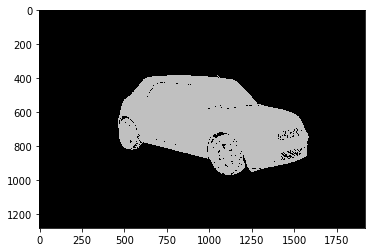

In [220]:
plt.imshow(thres1_3chan)

### Approach-3-1: pixel wise 

In [69]:
### pixel wise approach

#im = Image.open("./foregroundimg_grayscale_3chan.jpg") # this method is to open from jpg 
im= Image.fromarray(foregroundimg_grayscale_3chan)
# this method is to open from array, since we are not saving greyscale as jpg, and reading in on the fly
pixelMap = im.load()

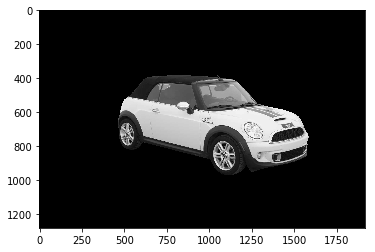

In [70]:
plt.imshow(foregroundimg_grayscale_3chan)

In [71]:
img = Image.new( im.mode, im.size)


In [72]:
pixelsNew = img.load()


In [73]:
max(pixelsNew[10,10])

0

In [74]:
for i in range(img.size[0]):
    for j in range(img.size[1]):
        if min(pixelMap[i,j]) > 60:
            pixelsNew[i,j] = (40,40,40,255)
            #pixelsNew[i,j] = (0,0,0,255)
        else:
            pixelsNew[i,j] = pixelMap[i,j]
im.close()
img.show()       
img.save("out.jpg") 
img.close()

In [75]:
# file = BytesIO()
# img.save(file, 'png')

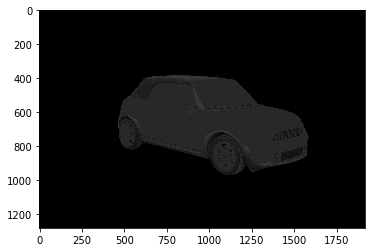

In [76]:
out=cv2.imread("./out.jpg")
plt.imshow(out)

In [77]:
out.shape,out.dtype

((1280, 1918, 3), dtype('uint8'))

### Approach-4: Embossing images 

In [78]:
img_emboss_input = cv2.imread('foregroundimg.jpg')
# generating the kernels
kernel_emboss_1 = np.array([[0,-1,-1],
[1,0,-1],
[1,1,0]])
kernel_emboss_2 = np.array([[-1,-1,0],
[-1,0,1],
[0,1,1]])
kernel_emboss_3 = np.array([[1,0,0],
[0,0,0],
[0,0,-1]])

In [79]:
# # applying the kernels to the grayscale image and adding the offset
# output_1 = cv2.filter2D(out, -1, kernel_emboss_1) + 128
# output_1 = output_1.astype(np.uint8)
# output_2 = cv2.filter2D(out, -1, kernel_emboss_2) + 128
# output_2 = output_2.astype(np.uint8)
# output_3 = cv2.filter2D(out, -1, kernel_emboss_3) + 128
# output_3 = output_3.astype(np.uint8)

In [80]:
# applying the kernels to the grayscale image and adding the offset
output_1 = cv2.filter2D(img_emboss_input, -1, kernel_emboss_1) + 40
output_1 = output_1.astype(np.uint8)
output_2 = cv2.filter2D(img_emboss_input, -1, kernel_emboss_2) + 40
output_2 = output_2.astype(np.uint8)
output_3 = cv2.filter2D(img_emboss_input, -1, kernel_emboss_3) + 40
output_3 = output_3.astype(np.uint8)

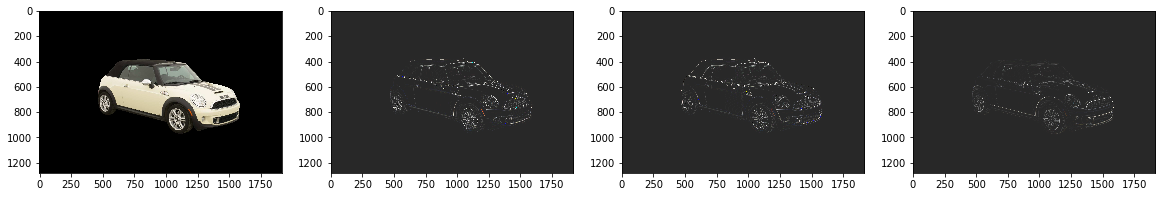

In [81]:
plt.figure(figsize=(20,20))

plt.subplot(141)
plt.imshow(img_emboss_input)
plt.subplot(142)
plt.imshow(output_1)
plt.subplot(143)
plt.imshow(output_2)
plt.subplot(144)
plt.imshow(output_3)

In [82]:
output_1.shape, output_2.shape,output_3.shape

((1280, 1918, 3), (1280, 1918, 3), (1280, 1918, 3))

### Approach-5: Edge detection 

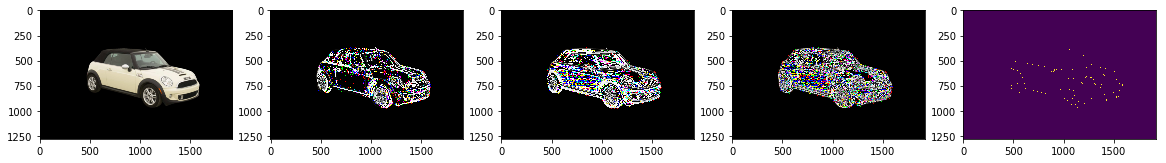

In [175]:
img_edgedet_base = cv2.imread("foregroundimg.jpg")
img_edgedet_base = cv2.GaussianBlur(img_edgedet_base, (11, 11), 0)
sobelx = cv2.Sobel(img_edgedet_base, cv2.CV_64F, 1, 0)
sobelx = sobelx.astype(np.uint8)
sobely = cv2.Sobel(img_edgedet_base, cv2.CV_64F, 0, 1)
sobely = sobely.astype(np.uint8)
laplacian = cv2.Laplacian(img_edgedet_base, cv2.CV_64F, ksize=5)
laplacian = laplacian.astype(np.uint8)
canny = cv2.Canny(img_edgedet_base, 0, 300)
#canny = cv2.Canny(img_edgedet_base, 100, 150)
plt.figure(figsize=(20,20))

plt.subplot(151)
plt.imshow(img_edgedet_base)
plt.subplot(152)
plt.imshow(sobelx)
plt.subplot(153)
plt.imshow(sobely)
plt.subplot(154)
plt.imshow(laplacian)
plt.subplot(155)
plt.imshow(canny)

In [176]:
img_edgedet_base.shape,sobelx.shape,sobely.shape,laplacian.shape,canny.shape

((1280, 1918, 3),
 (1280, 1918, 3),
 (1280, 1918, 3),
 (1280, 1918, 3),
 (1280, 1918))

In [177]:
# # import the necessary packages
# import numpy as np
# import argparse
# import glob
# import cv2

# def auto_canny(image, sigma=0.33):
# 	# compute the median of the single channel pixel intensities
# 	v = np.median(image)
 
# 	# apply automatic Canny edge detection using the computed median
# 	lower = int(max(0, (1.0 - sigma) * v))
# 	upper = int(min(255, (1.0 + sigma) * v))
# 	edged = cv2.Canny(image, lower, upper)
 
# 	# return the edged image
# 	return edged

In [178]:
#canny=auto_canny(img_edgedet_base)

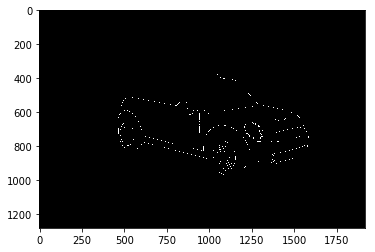

In [179]:
canny = np.stack((canny,)*3, axis=-1)
#cv2.imwrite('./',foregroundimg_grayscale_3chan)
plt.imshow(canny)

In [180]:
#plt.imshow(foregroundimg)

In [87]:
#del img_edgedet_base, sobelx, sobely, canny, laplacian,img

### Read background images

In [88]:
# h,w=foregroundimg_grayscale.shape
# h,w

In [89]:
# put backgroung images in a list

background_images = [file for file in glob('./images/*.jpg')]
len(background_images)

404

In [90]:
background_images.sort(reverse=False)

In [91]:
background_images

['./images/00000000.jpg',
 './images/00000001.jpg',
 './images/00000002.jpg',
 './images/00000003.jpg',
 './images/00000004.jpg',
 './images/00000005.jpg',
 './images/00000006.jpg',
 './images/00000007.jpg',
 './images/00000008.jpg',
 './images/00000009.jpg',
 './images/00000010.jpg',
 './images/00000011.jpg',
 './images/00000012.jpg',
 './images/00000013.jpg',
 './images/00000014.jpg',
 './images/00000015.jpg',
 './images/00000017.jpg',
 './images/00000018.jpg',
 './images/00000020.jpg',
 './images/00000021.jpg',
 './images/00000022.jpg',
 './images/00000023.jpg',
 './images/00000024.jpg',
 './images/00000025.jpg',
 './images/00000026.jpg',
 './images/00000027.jpg',
 './images/00000028.jpg',
 './images/00000029.jpg',
 './images/00000031.jpg',
 './images/00000032.jpg',
 './images/00000033.jpg',
 './images/00000034.jpg',
 './images/00000035.jpg',
 './images/00000036.jpg',
 './images/00000037.jpg',
 './images/00000038.jpg',
 './images/00000039.jpg',
 './images/00000040.jpg',
 './images/0

In [92]:
# reading a background image from background images folder and resizig it to the size of mask image
z=0
image_ids=[]
for i in range(1):
    img = cv2.imread(background_images[1])
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except: 
        continue     
    #for i in range(len(train_ids)):
    for i in range(1):  
        image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask = get_image_data(image_id, "Train_mask") 
        h,w = np.size(mask,0),np.size(mask,1)
        img_resized= cv2.resize(img,(int(w),int(h)))

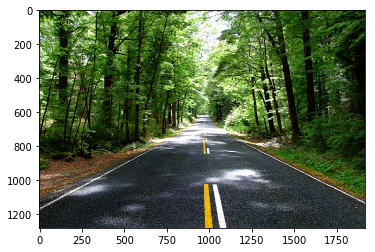

In [93]:
plt.imshow(img_resized)

In [94]:
#plt.imshow(blank_image+foregroundimg+img_resized)

In [95]:
img_resized.dtype

dtype('uint8')

In [96]:
img_shadow=img_resized.copy()
img_silver=img_resized.copy()
img_sunlight=img_resized.copy()
img_dimgrey=img_resized.copy()
img_grey=img_resized.copy()
img_notint=img_resized.copy()
img_noise=img_resized.copy()

In [97]:
shadow=[138,121,93]
silver=[192,192,192]
sunlight= [241,218,164]
#dimgrey= [105,105,105]
dimgrey=[191,255,0] #actually lime
#grey=[128,128,128]
grey=[40,40,40] 
#grey=[200,200,200]  #blackishtint
notint=[0,0,0]

black,silver and grey masks


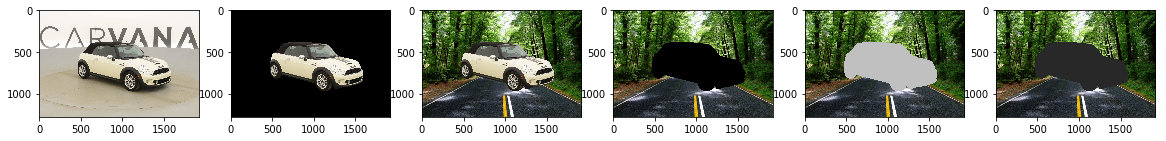

In [98]:
plt.figure(figsize=(20, 20))

img_silver[mask == 1] = silver 
img_notint[mask ==1]= notint
img_grey[mask ==1]= grey
plt.subplot(161)
plt.imshow(test_img)
plt.subplot(162)
plt.imshow(foregroundimg)
plt.subplot(163)
#plt.imshow(cv2.add(foregroundimg, img_notint))
plt.imshow((foregroundimg+img_notint))
plt.subplot(164)
plt.imshow(img_notint)
plt.subplot(165)
plt.imshow(img_silver)
plt.subplot(166)
plt.imshow(img_grey)
print("black,silver and grey masks")


various masks


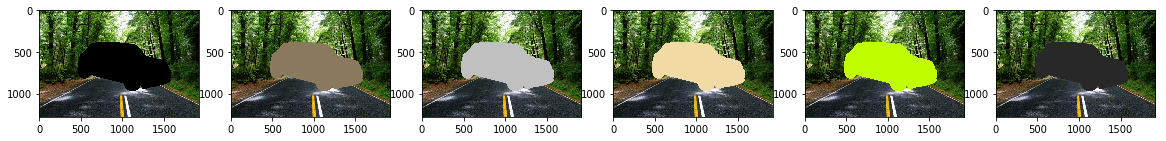

In [99]:
plt.figure(figsize=(20, 20))

img_shadow[mask == 1] = shadow
img_silver[mask == 1] = silver
img_sunlight[mask == 1] = sunlight
img_dimgrey[mask == 1] = dimgrey
img_grey[mask == 1] =grey 
img_notint[mask ==1]= notint

plt.subplot(161)
plt.imshow(img_notint)
plt.subplot(162)
plt.imshow(img_shadow)
plt.subplot(163)
plt.imshow(img_silver)
plt.subplot(164)
plt.imshow(img_sunlight)
plt.subplot(165)
plt.imshow(img_dimgrey)
plt.subplot(166)
plt.imshow(img_grey)
print("various masks")

## Results: Approach-2: Tint variation


Various tints


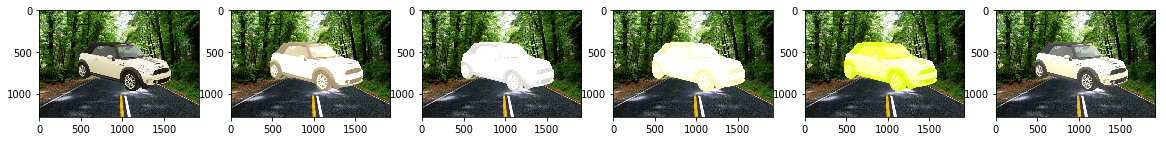

In [100]:
# tint variation
plt.figure(figsize=(20, 20))
plt.subplot(161)
plt.imshow(cv2.add(foregroundimg, img_notint))
plt.subplot(162)
plt.imshow(cv2.add(foregroundimg, img_shadow))
plt.subplot(163)
plt.imshow(cv2.add(foregroundimg, img_silver))
plt.subplot(164)
plt.imshow(img_sunlight)
plt.imshow(cv2.add(foregroundimg, img_sunlight))
plt.subplot(165)
plt.imshow(cv2.add(foregroundimg, img_dimgrey))
plt.subplot(166)
plt.imshow(cv2.add(foregroundimg, img_grey))
print("Various tints")

In [101]:
mask.shape

(1280, 1918)

Various tints


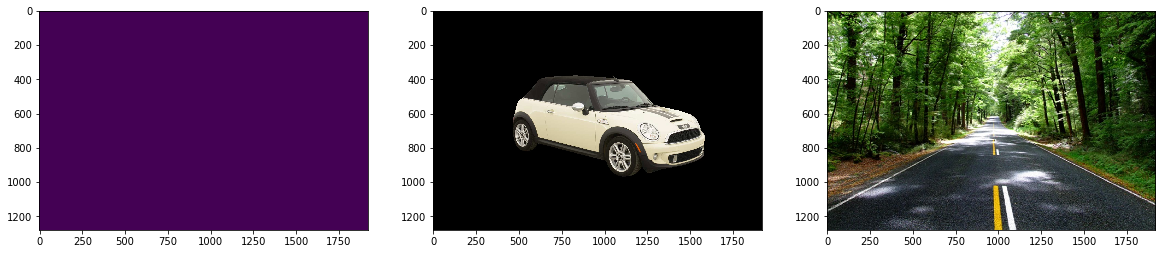

In [102]:
#blank_image = np.zeros((foregroundimg.shape[0],foregroundimg.shape[1],3), np.uint8)
blank_image = np.zeros((foregroundimg.shape[0],foregroundimg.shape[1]), np.uint8)
blank_image[mask == 1] = [0]
img_blankimage=img_resized.copy()


plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(blank_image)
plt.subplot(132)
plt.imshow(foregroundimg)
plt.subplot(133)
img_blankimage[blank_image == 1] =[0,0,0]
plt.imshow(img_blankimage)
#plt.subplot(164)
#plt.imshow(img_sunlight)
#plt.imshow(cv2.add(foregroundimg, img_sunlight))
#plt.subplot(165)
#plt.imshow(cv2.add(foregroundimg, img_dimgrey))
#plt.subplot(166)
#plt.imshow(cv2.add(foregroundimg, img_grey))
print("Various tints")

## Results: Approach-2: Background and Foreground intensity variation


various tints+ intesity change of background and foreground


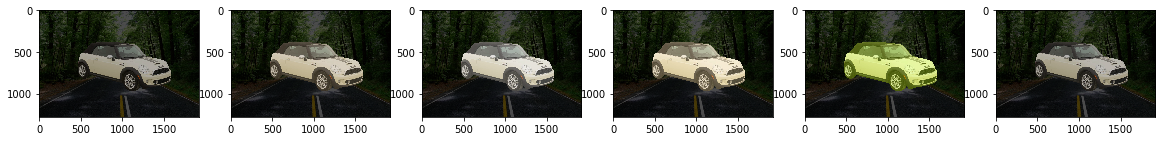

In [103]:
# background and foreground intensity variation
# reducing weightage of background image, cropped car 
#plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_resized, 0.3, 0) )

plt.figure(figsize=(20, 20))
plt.subplot(161)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_notint, 0.3, 0) )
plt.subplot(162)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_shadow, 0.3, 0) )
plt.subplot(163)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_silver, 0.3, 0) )
plt.subplot(164)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_sunlight, 0.3, 0) )
plt.subplot(165)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_dimgrey, 0.3, 0) )
plt.subplot(166)
plt.imshow(cv2.addWeighted(foregroundimg, 0.7, img_grey, 0.3, 0) )
print('various tints+ intesity change of background and foreground')

## Results: Approach-2: Car tint variation with background noise


various tints+random noise


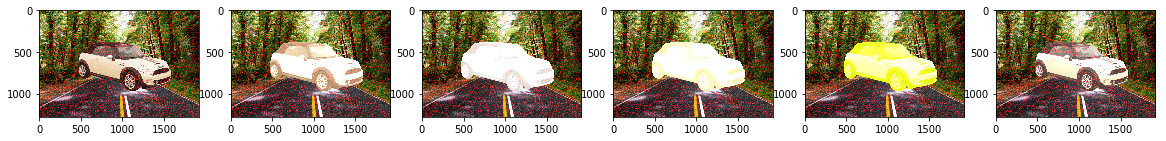

In [104]:
# car tint variation with background noise
cv2.randn(img_noise,(0),(99)) 
plt.figure(figsize=(20, 20))

plt.subplot(161)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_notint))

plt.subplot(162)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_shadow))

plt.subplot(163)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_silver))

plt.subplot(164)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_sunlight))

plt.subplot(165)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_dimgrey))

plt.subplot(166)
temp=(cv2.add(foregroundimg, img_noise))
plt.imshow(cv2.add(temp, img_grey))

print('various tints+random noise')

In [105]:
# cv2.randn(img_noise,(0),(99)) 
# plt.figure(figsize=(20, 20))
# plt.subplot(131)
# plt.imshow(img_resized)
# plt.subplot(132)
# plt.imshow(cv2.add(img_noise, foregroundimg))
# plt.subplot(133)
# plt.imshow(img_noise)

In [106]:
#del img_resized,test_img

## Results Approach-3: Manipulating pixel values of gray scale foreground image to get grey masked car (Thresholding)

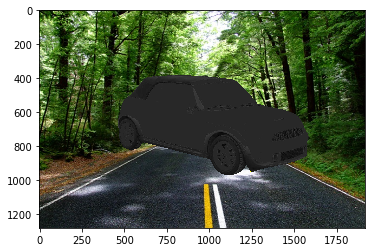

In [107]:
plt.imshow((out+img_notint))

<function imwrite>

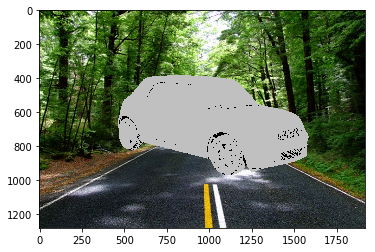

In [221]:
plt.imshow((thres1_3chan+img_notint))
cv2.imwrite

## Results: Approach-4: Embossing images 

foreground image, kernel_emboss_1, kernel_emboss_2, kernel_emboss_3


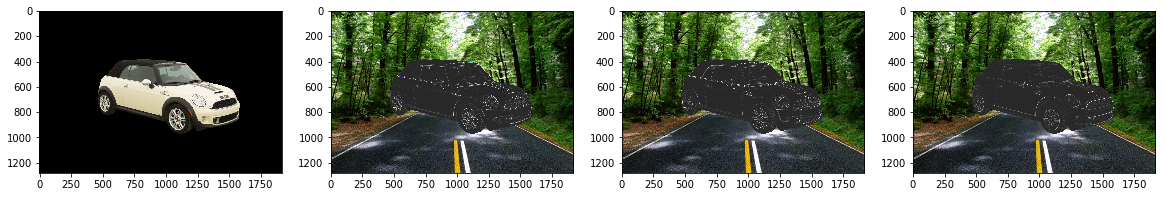

In [110]:
plt.figure(figsize=(20,20))
mask_here = mask.astype(np.uint8)
#mask_here=mask
plt.subplot(141)
plt.imshow(img_emboss_input)
plt.subplot(142)
output_1_masked = cv2.bitwise_and(output_1, output_1, mask=mask_here)
plt.imshow(output_1_masked+img_notint)
plt.subplot(143)
output_2_masked = cv2.bitwise_and(output_2, output_2, mask=mask_here)
plt.imshow(output_2_masked+img_notint)
plt.subplot(144)
output_3_masked = cv2.bitwise_and(output_3, output_3, mask=mask_here)
plt.imshow(output_3_masked+img_notint)
print("foreground image, kernel_emboss_1, kernel_emboss_2, kernel_emboss_3")

In [111]:
mask_here.dtype,output_1.dtype, mask_here.shape,output_1.shape

(dtype('uint8'), dtype('uint8'), (1280, 1918), (1280, 1918, 3))

## Results: Approach-5: Edge detection 


foreground+background (f+b) ,sobelx filter,sobely filter,laplacian filter,canny filter


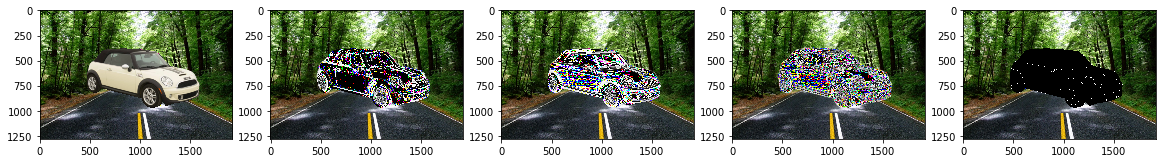

In [181]:
plt.figure(figsize=(20,20))

plt.subplot(151)
plt.imshow((img_edgedet_base+img_notint))
plt.subplot(152)
plt.imshow(sobelx+img_notint)
plt.subplot(153)
plt.imshow(sobely+img_notint)
plt.subplot(154)
plt.imshow(laplacian+img_notint)
#plt.imshow(cv2.add(laplacian, img_notint))
plt.subplot(155)
plt.imshow(canny+img_notint)
print("foreground+background (f+b) ,sobelx filter,sobely filter,laplacian filter,canny filter")

In [162]:
# #for i in range(len(train_ids)):
    
# image_id = train_ids[5]

# plt.figure(figsize=(20, 20))
# #mask = get_image_data(image_id, "Train_mask")
# laplacian_masked = cv2.bitwise_and(laplacian, laplacian, mask=mask)
# #cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), img_masked)
# #cv2.waitKey(0)
# plt.subplot(131)
# plt.imshow(laplacian_masked)
# plt.subplot(132)
# #plt.imshow(cv2.add(laplacian, img_notint))
# plt.imshow(laplacian_masked+img_notint)
# plt.subplot(133)
# plt.imshow(img_notint)

In [114]:
#plt.imshow(img_notint)

In [115]:
# laplacian.shape,img_notint.shape

In [116]:
#laplacian = laplacian.astype(np.uint8)

In [117]:
#plt.imshow(cv2.add(laplacian, img_notint))

## saving all inputs and outputs in a sample folder

True

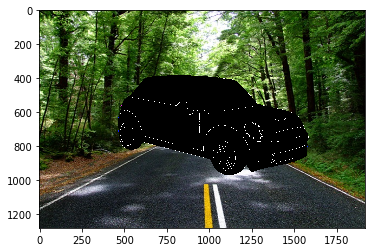

In [222]:
path = './input/sample_results/'
plt.imshow(canny+img_notint)
cv2.imwrite(os.path.join(path ,"canny"+".jpg"), canny+img_notint)
cv2.imwrite(os.path.join(path ,"laplacian"+".jpg"), laplacian+img_notint)
cv2.imwrite(os.path.join(path ,"output_2_masked+img_notint"+".jpg"), output_2_masked+img_notint)
cv2.imwrite(os.path.join(path ,"out+img_notint"+".jpg"), out+img_notint)
cv2.imwrite(os.path.join(path ,"+output_3_masked"+".jpg"), output_3_masked)
cv2.imwrite(os.path.join(path ,"img_notint"+".jpg"), img_notint)
cv2.imwrite(os.path.join(path ,"img_grey"+".jpg"), img_grey)
cv2.imwrite(os.path.join(path ,"test_img"+".jpg"), test_img)
cv2.imwrite(os.path.join(path ,"foregroundimg"+".jpg"), foregroundimg)
cv2.imwrite(os.path.join(path ,"foregroundimg+img_notint"+".jpg"), foregroundimg+img_notint)
cv2.imwrite(os.path.join(path ,"thres1_3chan+img_notint"+".jpg"), thres1_3chan+img_notint)


## Creating Background image+mask in black and silver 

In [88]:
path = './input/Background'

In [89]:
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]
for i in range(403):
    img = cv2.imread(background_images[i])
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except: 
        continue     
    #for i in range(len(train_ids)):
    for i in range(10):  
        image_id = train_ids[z+i]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask = get_image_data(image_id, "Train_mask") 
        h,w = np.size(mask,0),np.size(mask,1)
        img_resized= cv2.resize(img,(int(w),int(h)))
        if z>2500:
            img_resized[mask == 1] = b
        else:
            img_resized[mask == 1] = a
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), img_resized)
        

IndexError: tuple index out of range

In [ ]:
z

In [ ]:
final = [file for file in glob('./input/Background/*.jpg')]
len(final)

In [ ]:
final

In [ ]:
!ls ./input/Background | wc -l

In [ ]:
final[2009],train_ids[2009]

In [ ]:
img = cv2.imread("./images/"+"00000001.jpg")
plt.imshow(img)

In [ ]:
img_resized[mask == 1] = [0,0,0]
plt.imshow(img_resized)

In [ ]:
# complete_image=foregroundimg+img_resized
# plt.imshow(complete_image)

In [ ]:
# i, j = np.where(mask)
# indices = np.meshgrid(np.arange(min(i), max(i) + 1),
#                       np.arange(min(j), max(j) + 1),
#                       indexing='ij')
# sub_image = img_resized[indices]

In [ ]:
# plt.imshow(sub_image)

In [ ]:
# indices

In [ ]:
# i, j = np.where(mask)
# i

In [ ]:
#  Mat src=imread("box.png",1); //Your src  image
#  Mat tmp;
#  cvtColor(src,tmp,CV_BGR2GRAY);
#  vector< vector <Point> > contours; // Vector for storing contour
#  vector< Vec4i > hierarchy;
#  int largest_contour_index=0;
#  int largest_area=0;

# findContours( tmp, contours, hierarchy,CV_RETR_EXTERNAL, CV_CHAIN_APPROX_SIMPLE ); // Find the contours in the image
#  for( int i = 0; i< contours.size(); i++ ) // iterate through each contour.
#   {
#    double a=contourArea( contours[i],false);  //  Find the area of contour
#    if(a>largest_area){
#    largest_area=a;
#    largest_contour_index=i;                //Store the index of largest contour
#    }
#   }
#  Rect R= boundingRect(contours[largest_contour_index]);
#  rectangle( src, R, Scalar(0,255,0), 2, 8, 0 );
#  imshow("src",src);

In [ ]:
#!ls

In [ ]:
# where = np.array(np.where(mask))
# x1, y1 = np.amin(where, axis=1)
# x2, y2 = np.amax(where, axis=1)
# sub_image = img_resized[x1:x2, y1:y2]

In [ ]:
# plt.imshow(sub_image)

In [ ]:
# x1,y1

In [ ]:
# x2,y2

In [ ]:
# where

In [ ]:
# del bboxes_df

In [ ]:
train_ids[1]

## Creating background images with tint

In [ ]:
path = './input/Background_tint'

In [ ]:
z=0
shadow=[138,121,93]
silver=[192,192,192]
sunlight= [241,218,164]
dimgrey= [105,105,105]
image_ids=[]
for i in range(3):
    img = cv2.imread(background_images[i])
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except: 
        continue     
    #for i in range(len(train_ids)):
    for i in range(10):  
        image_id = train_ids[z+i]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask = get_image_data(image_id, "Train_mask") 
        foregroundimg= cv2.imread("./input/Foreground/"+str(image_id+".jpg"))
        foregroundimg = cv2.cvtColor(foregroundimg, cv2.COLOR_BGR2RGB)
        h,w = np.size(mask,0),np.size(mask,1)
        img_resized= cv2.resize(img,(int(w),int(h)))
        if z>2500:
            img_resized[mask == 1] = a
            tinted_image=cv2.add(foregroundimg, img_resized)
        else:
            img_resized[mask == 1] = b
            tinted_image=cv2.add(foregroundimg, img_resized)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), tinted_image)
        

In [ ]:
z

In [ ]:
final = [file for file in glob('./input/Background_tint/*.jpg')]
len(final)

In [ ]:
!ls ./input/Background_tint | wc -l

## Creating background images with embossing

### Use this for output

In [301]:
path = './input/Background_emboss/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]
kernel_emboss_3 = np.array([[1,0,0],
[0,0,0],
[0,0,-1]])
notint_emboss=[0,0,0]
for i in range(403): #403
    img_emboss = cv2.imread(background_images[i])
    #img_emboss = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(12):  #12
        image_id = train_ids[z+i]
        #image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_emboss = get_image_data(image_id, "Train_mask") 
        foregroundimg_emboss= cv2.imread("./input/Foreground/"+str(image_id)+".jpg")
        h,w = np.size(mask,0),np.size(mask_emboss,1)
        img_resized_emboss= cv2.resize(img_emboss,(int(w),int(h)))
        img_resized_emboss[mask_emboss ==1]= notint_emboss
        output_3_emboss = cv2.filter2D(foregroundimg_emboss, -1, kernel_emboss_3) + random.choice([40,192,0,138])
        output_3_masked_emboss = cv2.bitwise_and(output_3_emboss, output_3_emboss, mask=mask_emboss)
        #plt.imshow(output_3_masked+img_notint)
        #output_3 = output_3.astype(np.uint8)
        final= output_3_masked_emboss+img_resized_emboss
        #plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
        

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Trial for output

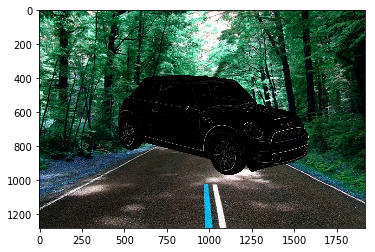

In [325]:
path = './input/Background_emboss/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]
kernel_emboss_3 = np.array([[1,0,0],
[0,0,0],
[0,0,-1]])
notint_emboss=[0,0,0]
for i in range(1): #403
    #img_emboss = cv2.imread(background_images[i])
    img_emboss = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(1):  #12
        #image_id = train_ids[z+i]
        image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_emboss = get_image_data(image_id, "Train_mask") 
        foregroundimg_emboss= cv2.imread("./input/Foreground/"+str(image_id)+".jpg")
        h,w = np.size(mask_emboss,0),np.size(mask_emboss,1)
        img_resized_emboss= cv2.resize( img_emboss,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        #mask_emboss_resized= cv2.resize( mask_emboss,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        img_resized_emboss[mask_emboss ==1]= notint_emboss
        output_3_emboss = cv2.filter2D(foregroundimg_emboss, -1, kernel_emboss_3) + random.choice([40,192,0,138])
        output_3_masked_emboss = cv2.bitwise_and(output_3_emboss, output_3_emboss, mask=mask_emboss)
        #plt.imshow(output_3_masked+img_notint)
        #output_3 = output_3.astype(np.uint8)
        final= output_3_masked_emboss+img_resized_emboss
        plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
        cv2.imwrite(os.path.join(path ,"img_resized_emboss"+".jpg"), img_resized_emboss)
        cv2.imwrite(os.path.join(path ,"mask_emboss_resized"+".jpg"), mask_emboss_resized)
        cv2.imwrite(os.path.join(path ,"mask_emboss"+".jpg"), mask_emboss)


## Creating background images with edge detection(canny filter)

### Use this for output

In [ ]:
path = './input/Background_edgedetection_canny/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]

notint_canny=[0,0,0]
for i in range(403): #403
    img_canny = cv2.imread(background_images[i])
    #img_canny = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(12):  #12
        image_id = train_ids[z+i]
        #image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_canny = get_image_data(image_id, "Train_mask") 
        foregroundimg_canny= cv2.imread("./input/Foreground/"+str(image_id)+".jpg")
        h,w = np.size(mask_canny,0),np.size(mask_canny,1)
        img_resized_canny= cv2.resize( img_canny,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        img_resized_canny[mask_canny ==1]= notint_canny
        
        #real stuff
        canny = cv2.Canny(foregroundimg_canny, 0, 300) #random.choice([40,192,0,138])
        canny = np.stack((canny,)*3, axis=-1)
        final= canny+img_resized_canny
    
        plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)

### Trial for output

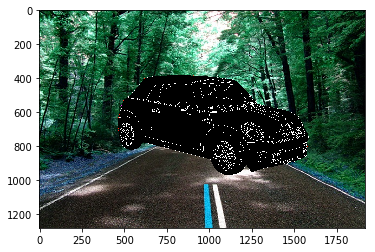

In [114]:
path = './input/Background_edgedetection_canny/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]

notint_canny=[0,0,0]
for i in range(1): #403
    #img_emboss = cv2.imread(background_images[i])
    img_canny = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(1):  #12
        #image_id = train_ids[z+i]
        image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_canny = get_image_data(image_id, "Train_mask") 
        foregroundimg_canny= cv2.imread("./input/Foreground/"+str(image_id)+".jpg")
        h,w = np.size(mask_canny,0),np.size(mask_canny,1)
        img_resized_canny= cv2.resize( img_canny,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        #mask_emboss_resized= cv2.resize( mask_emboss,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        img_resized_canny[mask_canny ==1]= notint_canny
        
        #real stuff
        canny = cv2.Canny(foregroundimg_canny, 100, 150) #random.choice([40,192,0,138])
        canny = np.stack((canny,)*3, axis=-1)
        final= canny+img_resized_canny
    
        plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
        cv2.imwrite(os.path.join(path ,"img_resized_canny"+".jpg"), img_resized_canny)
        cv2.imwrite(os.path.join(path ,"canny"+".jpg"), canny)
        #cv2.imwrite(os.path.join(path ,"mask_emboss"+".jpg"), mask_emboss)


### logic for resetting loop

In [ ]:
# # logic to run i loop 5 times and j loop 3 times. 
# j=0
# for i in range(5): # 400 background images
#     #print(i)
#     condition=True
#     while condition:
#         print(j)
#         j+=1
#         if j==3:
#             condition=False
#             j=0


In [ ]:
# for i in range(0,3):
#     for j in range(0,5):
#         print(i,j)

## Creating background images with Thresholding - pixel wise (slow)

### Use this for output

KeyboardInterrupt: 

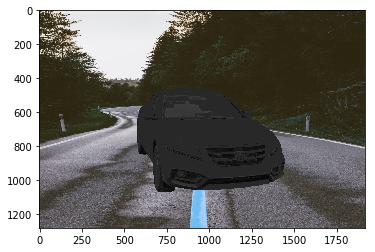

In [135]:
path = './input/Background_threshold/'
path_temp= './input/Background_threshold/temp/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]

notint_thresh=[0,0,0]
for i in range(403): #403
    img_thresh = cv2.imread(background_images[i])
    #img_thresh = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(12):  #12
        image_id = train_ids[z+i]
        #image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_thresh = get_image_data(image_id, "Train_mask") 
        foregroundimg_thresh= cv2.imread("./input/Foreground/"+str(image_id)+".jpg",0)
        foregroundimg_thresh = np.stack((foregroundimg_thresh,)*3, axis=-1)
        h,w = np.size(mask_thresh,0),np.size(mask_thresh,1)
        
        
        img_resized_thresh= cv2.resize( img_thresh,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        #mask_emboss_resized= cv2.resize( mask_emboss,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        img_resized_thresh[mask_thresh ==1]= notint_thresh
        
        #real stuff
        im= Image.fromarray(foregroundimg_thresh)
        pixelMap = im.load()
        img = Image.new( im.mode, im.size)
        pixelsNew = img.load()
        for i in range(img.size[0]):
            for j in range(img.size[1]):
                if min(pixelMap[i,j]) > 60:
                    pixelsNew[i,j] = (40,40,40,255)
                    #pixelsNew[i,j] = (0,0,0,255)
                else:
                    pixelsNew[i,j] = pixelMap[i,j]
        im.close()
        img.save(path_temp+str(image_id)+".jpg")     
        out=cv2.imread(path_temp+str(image_id)+".jpg")
        final= img+img_resized_thresh
    
        #plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
        #cv2.imwrite(os.path.join(path ,"img_resized_thresh"+".jpg"), img_resized_thresh)
        #cv2.imwrite(os.path.join(path ,"thresh"+".jpg"), out)
        #cv2.imwrite(os.path.join(path ,"mask_emboss"+".jpg"), mask_emboss)


### Trial for output



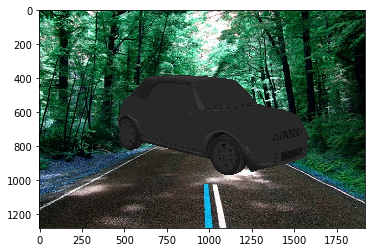

In [134]:
path = './input/Background_threshold/'
path_temp= './input/Background_threshold/temp/'
z=0
a=[0,0,0]
b=[192,192,192]
image_ids=[]

notint_thresh=[0,0,0]
for i in range(1): #403
    #img_emboss = cv2.imread(background_images[i])
    img_thresh = cv2.imread(background_images[1])
#     try:
#         img_emboss = cv2.cvtColor(img_emboss, cv2.COLOR_BGR2RGB)
#     except: 
#         continue     
    #for i in range(len(train_ids)):
    for i in range(1):  #12
        #image_id = train_ids[z+i]
        image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        #plt.figure(figsize=(20, 20))  
        mask_thresh = get_image_data(image_id, "Train_mask") 
        foregroundimg_thresh= cv2.imread("./input/Foreground/"+str(image_id)+".jpg",0)
        foregroundimg_thresh = np.stack((foregroundimg_thresh,)*3, axis=-1)
        h,w = np.size(mask_thresh,0),np.size(mask_thresh,1)
        img_resized_thresh= cv2.resize( img_thresh,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        #mask_emboss_resized= cv2.resize( mask_emboss,(int(w),int(h)), interpolation= cv2.INTER_AREA   )
        img_resized_thresh[mask_thresh ==1]= notint_thresh
        
        #real stuff
        im= Image.fromarray(foregroundimg_thresh)
        pixelMap = im.load()
        img = Image.new( im.mode, im.size)
        pixelsNew = img.load()
        for i in range(img.size[0]):
            for j in range(img.size[1]):
                if min(pixelMap[i,j]) > 60:
                    pixelsNew[i,j] = (40,40,40,255)
                    #pixelsNew[i,j] = (0,0,0,255)
                else:
                    pixelsNew[i,j] = pixelMap[i,j]
        im.close()
        img.save(path_temp+str(image_id)+".jpg")     
        out=cv2.imread(path_temp+str(image_id)+".jpg")
        final= img+img_resized_thresh
    
        plt.imshow(final)
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
        cv2.imwrite(os.path.join(path ,"img_resized_thresh"+".jpg"), img_resized_thresh)
        cv2.imwrite(os.path.join(path ,"thresh"+".jpg"), out)
        #cv2.imwrite(os.path.join(path ,"mask_emboss"+".jpg"), mask_emboss)


## Creating background images with Thresholding - (fast)

### Use this for output

### Trial for output

## Creating background images-function

In [277]:
#path = './input/Background_function_mix/'
path = './input/delete/'
z=0
image_ids=[]
notint=[0,0,0]
my_list=list(range(403))

for i in tqdm(range(403)):
    
    img = cv2.imread(background_images[i])
    for i in range(12):  #12
        
        #pre-processing: 
        
        image_id = train_ids[z+i]
        #image_id = train_ids[5]
        image_ids.append(image_id)   
        z+=1
        mask = get_image_data(image_id, "Train_mask")
        foregroundimg_grayscale= cv2.imread("./input/Foreground/"+str(image_id)+".jpg",0)
        foregroundimg = cv2.imread("./input/Foreground/"+str(image_id)+".jpg")
        h,w = np.size(mask,0),np.size(mask,1)
        try:
            img_resized= cv2.resize( img,(int(w),int(h)), interpolation= cv2.INTER_AREA)
        except:
            continue  
        img_resized[mask ==1]= notint
        
        
        #real stuff
        
        low=random.choice([20,40])
        if low==20:
            high=192
        else:
            high=40

        def thresholding():
            _,thresh1 = cv2.threshold(foregroundimg_grayscale,low,high,cv2.THRESH_BINARY) # [20,192], [40,40]
            pre_final= cv2.cvtColor(thresh1.copy(),cv2.COLOR_GRAY2RGB)
            return pre_final
        def edgedetection():
            canny = cv2.Canny(foregroundimg, 0, 300) #random.choice([40,192,0,138])
            pre_final = np.stack((canny,)*3, axis=-1)
            return pre_final
        
        functions=[thresholding(),edgedetection()]
        random.choice(functions)
        
        #final image
        final= random.choice(functions)+img_resized
    
        cv2.imwrite(os.path.join(path ,str(image_id)+".jpg"), final)
  

KeyboardInterrupt: 

In [231]:
#random.choice([40,192,0,138])

## Creating bouding boxes csv

In [281]:
#bboxes_dict = {}
final = [file for file in glob('./input/Background_function_mix/*.jpg')]
bboxes_df = pd.DataFrame()
#for i in range(len(train_ids)):
for i in tqdm(range(len(final))):
    base = (os.path.basename(final[i]))
    image_id=os.path.splitext(base)[0]
    mask = get_image_data(image_id, "Train_mask") 
    where = np.array(np.where(mask))
    x1, y1 = np.amin(where, axis=1)
    x2, y2 = np.amax(where, axis=1)
    #bboxes = {'image': "./input/train/"+image_id+".jpg",'x1':x1,'y1':y1,'x2':x2, 'y2':y2,'class':'car'}
    #need to swap x and y because cartesian corrdinates are swapped in numpy array where its row major, 
    #i.e x is y and y is x
    bboxes = {'image': "./input/train/"+image_id+".jpg",'x1':y1,'y1':x1,'x2':y2, 'y2':x2,'class':'car'}   
    bboxes_df=bboxes_df.append(bboxes, ignore_index=True)
#     df.append([bboxes_dict])

In [ ]:
# #bboxes_dict = {}
# bboxes_df = pd.DataFrame()
# #for i in range(len(train_ids)):
# for i in range(5000):
#     image_id = train_ids[i]
#     mask = get_image_data(image_id, "Train_mask") 
#     where = np.array(np.where(mask))
#     x1, y1 = np.amin(where, axis=1)
#     x2, y2 = np.amax(where, axis=1)
#     bboxes = {'image': "./input/train/"+image_id+".jpg",'x1':x1,'y1':y1,'x2':x2, 'y2':y2,'class':'car'}
#     bboxes_df=bboxes_df.append(bboxes, ignore_index=True)
# #     df.append([bboxes_dict])

In [242]:
#bboxes_df = pd.DataFrame([bboxes_dict])
#bboxes_df = bboxes_df.transpose()
#bboxes_df.columns = ['bbox_list']
#bboxes_df.index.name = 'img'
bboxes_df.head()

,class,image,x1,x2,y1,y2
0,car,./input/train/61060ada97c9_05.jpg,170.0,854.0,5.0,1917.0
1,car,./input/train/42a3297ccd4b_01.jpg,388.0,1045.0,541.0,1280.0
2,car,./input/train/42b3feca1993_13.jpg,214.0,928.0,87.0,1864.0
3,car,./input/train/9cc257b449d0_05.jpg,332.0,934.0,321.0,1501.0
4,car,./input/train/bb2f95262773_10.jpg,264.0,876.0,409.0,1291.0


In [243]:
bboxes_df.to_csv('bbox_dictionary.csv',index=False,header= False)

In [244]:
bboxes_df.shape

(2424, 6)

In [ ]:
del df

In [ ]:
bboxes

In [ ]:
df=pd.DataFrame()

In [ ]:
df=df.append(bboxes, ignore_index=True)

In [ ]:
df

In [ ]:
# import os
# import cv2
# import csv
# from tqdm import tqdm
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from skimage.io import imread
# import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
# from skimage.measure import label, regionprops
# #from skimage.util.montage import montage2d as montage
# #montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = './input'
# train_image_dir = os.path.join(ship_dir, 'train')
# test_image_dir = os.path.join(ship_dir, 'test')

# from skimage.morphology import label
# def multi_rle_encode(img):
#     labels = label(img[:, :, 0])
#     return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# def rle_encode(img):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     pixels = img.T.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)

# def rle_decode(mask_rle, shape=(1280, 1918)):
#     '''
#     mask_rle: run-length as string formated (start length)
#     shape: (height,width) of array to return 
#     Returns numpy array, 1 - mask, 0 - background
#     '''
#     s = mask_rle.split()
#     starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#     starts -= 1
#     ends = starts + lengths
#     img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
#     for lo, hi in zip(starts, ends):
#         img[lo:hi] = 1
#     return img.reshape(shape).T  # Needed to align to RLE direction

# def masks_as_image(in_mask_list, all_masks=None):
#     # Take the individual ship masks and create a single mask array for all ships
#     if all_masks is None:
#         all_masks = np.zeros((1280, 1918), dtype = np.int8)
#     #if isinstance(in_mask_list, list):
#     for mask in in_mask_list:
#         if isinstance(mask, str):
#             all_masks += rle_decode(mask)
#     return np.expand_dims(all_masks, -1)

In [ ]:
# masks = pd.read_csv(os.path.join('./input',
#                                  'train_masks.csv'))
# print(masks.shape[0], 'masks found')
# print(masks['img'].value_counts().shape[0])
# masks.head()

In [ ]:
# images_with_ship = masks.img[masks.rle_mask.isnull()==False]
# images_with_ship = np.unique(images_with_ship.values)
# print('There are ' +str(len(images_with_ship)) + ' image files with masks')

In [ ]:
# for i in range(10):
#     image = images_with_ship[i]

#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
#     img_0 = cv2.imread(train_image_dir+'/' + image)
#     rle_0 = masks.query('img=="'+image+'"')['rle_mask']
#     mask_0 = masks_as_image(rle_0)
#     #
#     # 
#     lbl_0 = label(mask_0) 
#     props = regionprops(lbl_0)
#     img_1 = img_0.copy()
#     print ('Image', image)
#     for prop in props:
#         print('Found bbox', prop.bbox)
#         cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


#     ax1.imshow(img_0)
#     ax1.set_title('Image')
#     ax2.set_title('Mask')
#     ax3.set_title('Image with derived bounding box')
#     ax2.imshow(mask_0[...,0])
#     ax3.imshow(img_1)
#     plt.show()

In [ ]:
#rle_0

In [ ]:
#masks.head()

In [ ]:
#images_with_ship 

In [ ]:
!ls

In [ ]:
from fastai.vision import *

In [ ]:
download_images("./download","./images")

In [ ]:
!ls .

In [ ]:
!ls

In [3]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [261]:
! pip uninstall -y progressbar

Uninstalling progressbar-2.5:
  Successfully uninstalled progressbar-2.5


In [263]:
! pip install progressbar2

In [279]:
import time
import progressbar

widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]
for i in progressbar.progressbar(range(20), widgets=widgets):
    time.sleep(0.1)

TypeError: 'module' object is not callable

In [280]:
import time
import progressbar

for i in progressbar.progressbar(range(100)):
    time.sleep(0.02)


TypeError: 'module' object is not callable